### Project setup

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pickle

%matplotlib inline

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


In [6]:
image = mpimg.imread('test_images/cutout1.jpg')

In [7]:
cars = pickle.load(open('data/car_imgs.p', 'rb'))
notcars = pickle.load(open('data/non_car_imgs.p', 'rb'))

## Helpful Extracted functions

In [8]:
def convert_colorspace(img, color_space='RGB'):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb' or color_space == 'YCC':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    return feature_image

### Histograms of Color

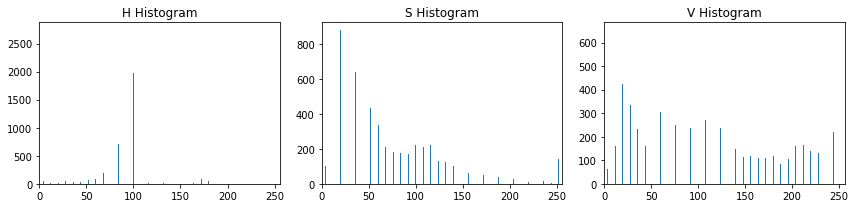

In [9]:
# Define a function to compute color histogram features  
def color_hist_ext(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
def plot_color_hist(image, color_space='RGB'):
    cs_img = convert_colorspace(image, color_space)
    rh, gh, bh, bincen, feature_vec = color_hist_ext(cs_img, nbins=32, bins_range=(0, 256))

    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title(color_space[0]+' Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title(color_space[1]+' Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title(color_space[2]+' Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')
        
plot_color_hist(image, 'HSV')

### Explore Color Spaces

#### Potential framework for 3d viewing - https://github.com/tody411/ColorHistogram

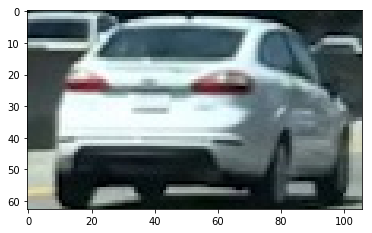

In [10]:
plt.imshow(image)

In [11]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def plot_colorspace3d(img, color_space):
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = convert_colorspace(img_small, 'RGB')
    img_small_HSV = convert_colorspace(img_small, color_space)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plot3d(img_small_HSV, img_small_rgb, axis_labels=list(color_space))
    plt.show()
    
    

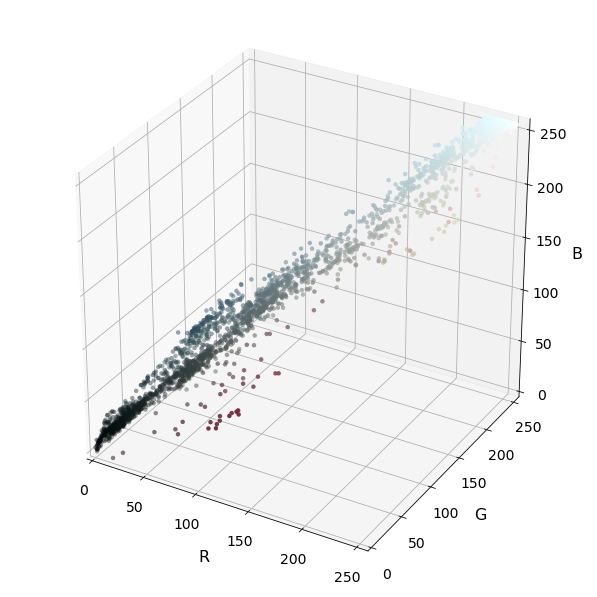

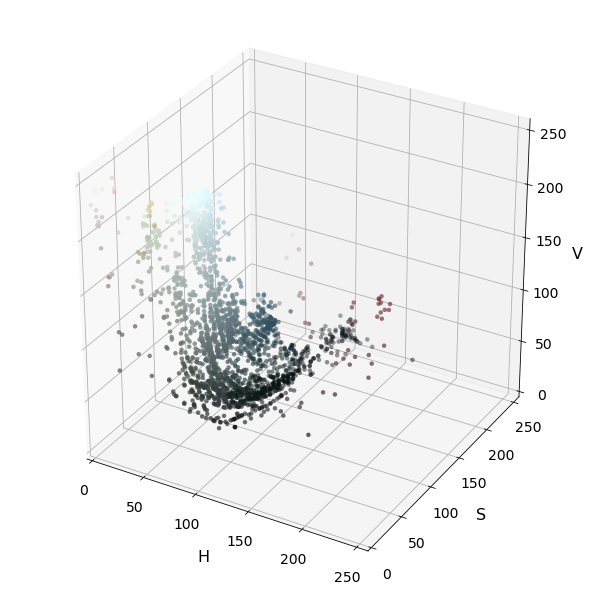

In [12]:

# Read a color image
# img = cv2.imread("000275.png")
plot_colorspace3d(image, 'RGB')
plot_colorspace3d(image, 'HSV')
# plot_colorspace3d(image, 'LUV')
# plot_colorspace3d(image, 'HLS')
# plot_colorspace3d(image, 'YUV')

## Spacial Binning of Color

In [13]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
    
def plot_bin_spatial(img):
    convert_img = convert_colorspace(image, 'RGB')
    feature_vec = bin_spatial(convert_img, size=(32, 32))

    # Plot features
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')
    

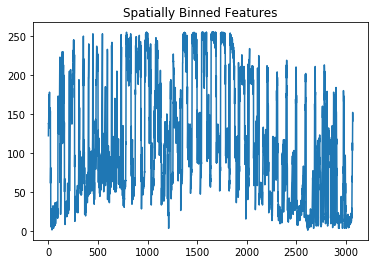

In [14]:

plot_bin_spatial(image)

### Combine and normalize features

In [15]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        feature_image = convert_colorspace(img, cspace)    
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


def load_color_features(cspace, spatial_size, hist_bins, hist_range):
    t=time.time()
    
    picklefile = cspace+'-'+str(spatial_size[0])+'-'+str(hist_bins)+'-'+str(hist_range[0])+'-'+str(hist_range[1])
    car_features_file = 'data/'+picklefile+'-car_color_features.p'
    notcar_features_file = 'data/'+picklefile+'-noncar_color_features.p'
    try:
        car_features = pickle.load(open(car_features_file, 'rb'))
        notcar_features = pickle.load(open(notcar_features_file, 'rb'))
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to load Color features from save...')
    except FileNotFoundError as e:
        
        car_features = extract_color_features(cars, cspace, spatial_size,
                                hist_bins, hist_range)
        notcar_features = extract_color_features(notcars, cspace, spatial_size,
                                hist_bins, hist_range)

        pickle.dump(car_features, open(car_features_file, "wb"))
        pickle.dump(notcar_features, open(notcar_features_file, "wb"))

        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract Color features...')
    return car_features, notcar_features


In [19]:
def visualize_features(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(cars[car_ind])
    plt.title('Original Image')
    plt.subplot(142)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(143)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    
    plt.subplot(144)
    mean_X = np.mean(scaled_X[:len(cars)], axis=1)
    plt.plot(mean_X)
    print(mean_X.shape)
    plt.title('Mean Norm Features')
    fig.tight_layout()


    notcar_ind = np.random.randint(0, len(notcars))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(notcars[notcar_ind])
    plt.title('Original Image')
    plt.subplot(142)
    plt.plot(X[notcar_ind+len(cars)])
    plt.title('Raw Features')
    plt.subplot(143)
    plt.plot(scaled_X[notcar_ind+len(cars)])
    plt.title('Normalized Features')
    fig.tight_layout()
    
    plt.subplot(144)
    mean_X = np.mean(scaled_X[len(cars):], axis=1)
    plt.plot(mean_X)
    print(mean_X.shape)
    plt.title('Mean Norm Features')
    fig.tight_layout()
    
    
def visualize_colorspace_features():
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCC']
    n_spaces = len(color_spaces)

    fig, axarr = plt.subplots(2, n_spaces, figsize=(20,8))
    for idx, color_space in enumerate(color_spaces):
        car_features, notcar_features = load_color_features(cspace=color_space, spatial_size=(32, 32),
                                hist_bins=32, hist_range=(0, 256))
        
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        car_ind = np.random.randint(0, len(cars))
        
        axarr[0, idx].set_title('Car Norm: '+color_space)
        mean_X = np.mean(scaled_X[:len(cars)], axis=1)
        axarr[0, idx].plot(mean_X)
        
        
        axarr[1, idx].set_title('Noncar Norm: '+color_space)
        mean_X = np.mean(scaled_X[len(cars):], axis=1)
        axarr[1, idx].plot(mean_X)
        
    fig.savefig('output_images/visualize_colorspace_features.png')
        


In [17]:
def visualize_colorspace(color_space='RGB', spatial=32, histbin=32, hist_range=(0,256)):
    car_features, notcar_features = load_color_features(cspace=color_space, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    visualize_features(car_features, notcar_features)

0.39 Seconds to load Color features from save...
0.62 Seconds to load Color features from save...
0.38 Seconds to load Color features from save...
0.38 Seconds to load Color features from save...
0.36 Seconds to load Color features from save...
0.37 Seconds to load Color features from save...


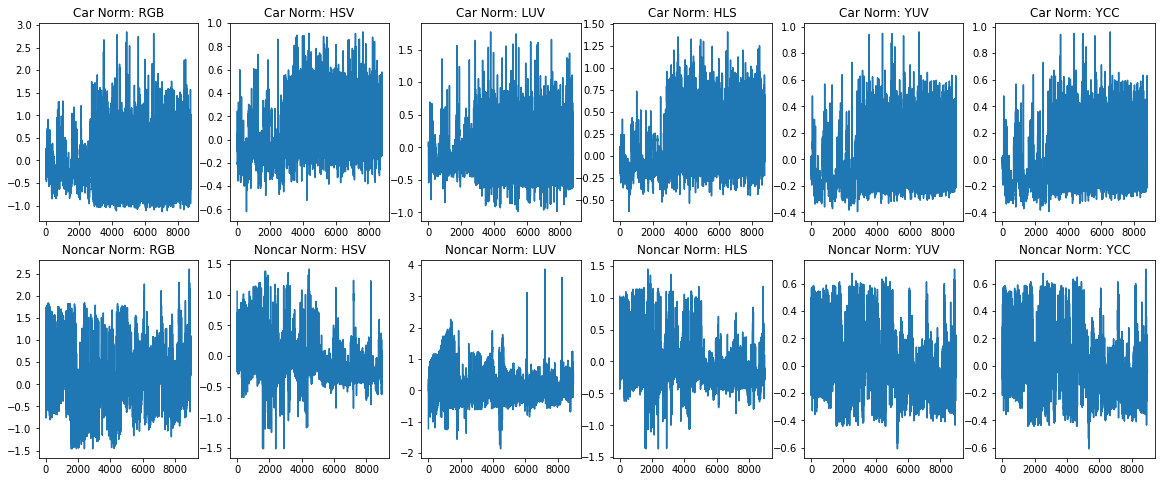

In [20]:
visualize_colorspace_features()

### Color Classify

In [13]:

def svc_predict(cars, notcars, color_space='RGB', spatial=16, histbin=32):
    car_features, notcar_features = load_color_features(cspace=color_space, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins.', 'Colorspace:', color_space)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    print('--------------------------------------------------------')

In [16]:
def predict_all_colorspaces():
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCC']
    for color_space in color_spaces:
        svc_predict(cars, notcars, color_space=color_space, spatial=32)

In [15]:
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCC']
for color_space in color_spaces:
    svc_predict(cars, notcars, color_space=color_space, spatial=16)

0.27 Seconds to load Color features from save...
Using spatial binning of: 16 and 32 histogram bins. Colorspace: RGB
Feature vector length: 864
14.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9215
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00108 Seconds to predict 10 labels with SVC
--------------------------------------------------------
6.85 Seconds to extract Color features...
Using spatial binning of: 16 and 32 histogram bins. Colorspace: HSV
Feature vector length: 864
12.48 Seconds to train SVC...
Test Accuracy of SVC =  0.92
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
0.00128 Seconds to predict 10 labels with SVC
--------------------------------------------------------
6.92 Seconds to extract Color features...
Using spatial binning of: 16 and 32 histogram bins. Colorspace: LUV
Feature vector length: 864
7.71 Sec

In [17]:
color_spaces = ['RGB', 'LUV', 'YCC', 'HSV', 'HLS', 'YUV']
for color_space in color_spaces:
    svc_predict(cars, notcars, color_space=color_space, spatial=32)

0.41 Seconds to load Color features from save...
Using spatial binning of: 32 and 32 histogram bins. Colorspace: RGB
Feature vector length: 3168
35.76 Seconds to train SVC...
Test Accuracy of SVC =  0.913
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
0.0016 Seconds to predict 10 labels with SVC
--------------------------------------------------------
0.42 Seconds to load Color features from save...
Using spatial binning of: 32 and 32 histogram bins. Colorspace: LUV
Feature vector length: 3168
22.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9375
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
0.0015 Seconds to predict 10 labels with SVC
--------------------------------------------------------
0.42 Seconds to load Color features from save...
Using spatial binning of: 32 and 32 histogram bins. Colorspace: YCC
Feature vector lengt

In [18]:
color_spaces = ['RGB', 'LUV', 'YCC', 'HSV', 'HLS', 'YUV']
for color_space in color_spaces:
    svc_predict(cars, notcars, color_space=color_space, spatial=8)

5.99 Seconds to extract Color features...
Using spatial binning of: 8 and 32 histogram bins. Colorspace: RGB
Feature vector length: 288
6.02 Seconds to train SVC...
Test Accuracy of SVC =  0.8992
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  1.  1.  1.  1.]
0.00111 Seconds to predict 10 labels with SVC
--------------------------------------------------------
6.75 Seconds to extract Color features...
Using spatial binning of: 8 and 32 histogram bins. Colorspace: LUV
Feature vector length: 288
4.86 Seconds to train SVC...
Test Accuracy of SVC =  0.962
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00133 Seconds to predict 10 labels with SVC
--------------------------------------------------------
6.64 Seconds to extract Color features...
Using spatial binning of: 8 and 32 histogram bins. Colorspace: YCC
Feature vector length: 288
6.66 Seconds to tra

In [19]:
color_spaces = ['RGB', 'LUV', 'YCC', 'HSV', 'HLS', 'YUV']
for color_space in color_spaces:
    svc_predict(cars, notcars, color_space=color_space, spatial=8, histbin=16)

6.58 Seconds to extract Color features...
Using spatial binning of: 8 and 16 histogram bins. Colorspace: RGB
Feature vector length: 240
7.23 Seconds to train SVC...
Test Accuracy of SVC =  0.8933
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
0.0013 Seconds to predict 10 labels with SVC
--------------------------------------------------------
6.86 Seconds to extract Color features...
Using spatial binning of: 8 and 16 histogram bins. Colorspace: LUV
Feature vector length: 240
4.63 Seconds to train SVC...
Test Accuracy of SVC =  0.944
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.00119 Seconds to predict 10 labels with SVC
--------------------------------------------------------
6.72 Seconds to extract Color features...
Using spatial binning of: 8 and 16 histogram bins. Colorspace: YCC
Feature vector length: 240
7.06 Seconds to trai